In [18]:
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tqdm import tqdm 
import seaborn as sns
import pandas as pd
import numpy as np
import parselmouth
import glob


In [31]:
# store filenames 
# speaker, session, emotion, start_time, content 
speech_files = glob.glob('speech_files/*wav')


In [56]:
# create neutral means list 
speech_feats = []
neutral_list = {}

for sf in tqdm(speech_files):
#     sf = speech_files[0]
#     feature extraction 
#     extracting min, max, mean of pitch and intensity 

    snd = parselmouth.Sound(sf)
    snd = snd.extract_left_channel()

    # pitch feature extraction 
    pitch = snd.to_pitch_ac(pitch_floor= 75, pitch_ceiling=600)
    pitch_values = pitch.selected_array['frequency']
    # remove zeros from pitch values analysis
    pitch_values = pitch_values[np.nonzero(pitch_values)]
    min_pitch  = np.min(pitch_values) 
    max_pitch  = np.max(pitch_values)
    mean_pitch = np.mean(pitch_values)

    # intensity feature extraction 
    intensity = snd.to_intensity()
    min_intensity  = intensity.get_minimum()
    max_intensity  = intensity.get_maximum()
    mean_intensity = intensity.get_average()
    
    # parse out folder and '_'
    speaker, session, emotion, start_time, content = sf.split('/')[1:][0].split('_')
    
    speech_feats.append([speaker, emotion, min_pitch,max_pitch,mean_pitch,
                min_intensity, max_intensity, mean_intensity])
    
#     if speaker in speech_feats: 
#         speech_feats[speaker].append([emotion, min_pitch,max_pitch,mean_pitch,
#                                       min_intensity, max_intensity, mean_intensity])
#     else: 
#         speech_feats[speaker] = [[emotion, min_pitch,max_pitch,mean_pitch,
#                                       min_intensity, max_intensity, mean_intensity]]
        
    if speaker in neutral_list: 
        if emotion == 'neutral': 
            neutral_list[speaker].append([min_pitch,max_pitch,mean_pitch,
                                      min_intensity, max_intensity, mean_intensity])
    else: 
        neutral_list[speaker] =[[min_pitch,max_pitch,mean_pitch,
                                      min_intensity, max_intensity, mean_intensity]]

100%|██████████| 2324/2324 [02:02<00:00, 18.93it/s]


In [59]:
from numpy import mean 

neutral_means = {}
for k in neutral_list: 
    neutral_means[k] = np.mean(neutral_list[k], axis=0)
    

In [87]:
norm_speech_feats = []
for i in speech_feats: 
    # normalize min pitch...mean intensity 
    temp = list(i[2:] - neutral_means[i[0]])
    # reappend to original speaker, emotion label 
    norm_speech_feats.append(i[:2] + temp)
    
# # make 12 plots         
df = pd.DataFrame(speech_feats,
                        columns=['speaker', 'emotion', 'min_pitch','max_pitch','mean_pitch',
                                'min_intensity', 'max_intensity', 'mean_intensity'])

norm_df = pd.DataFrame(norm_speech_feats, 
                        columns=['speaker', 'emotion', 'min_pitch','max_pitch','mean_pitch',
                                'min_intensity', 'max_intensity', 'mean_intensity'])


Index(['min_pitch', 'max_pitch', 'mean_pitch', 'min_intensity',
       'max_intensity', 'mean_intensity'],
      dtype='object')


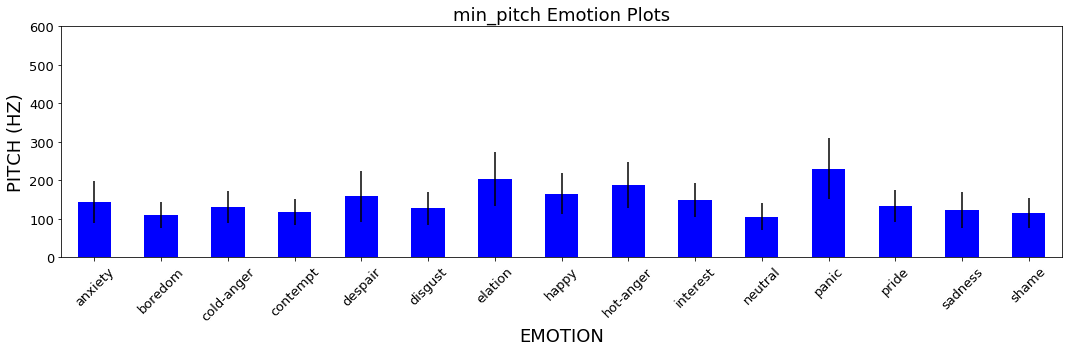

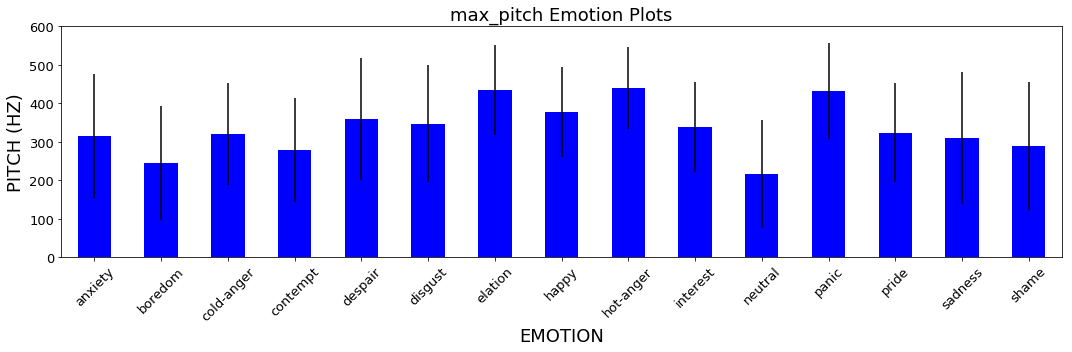

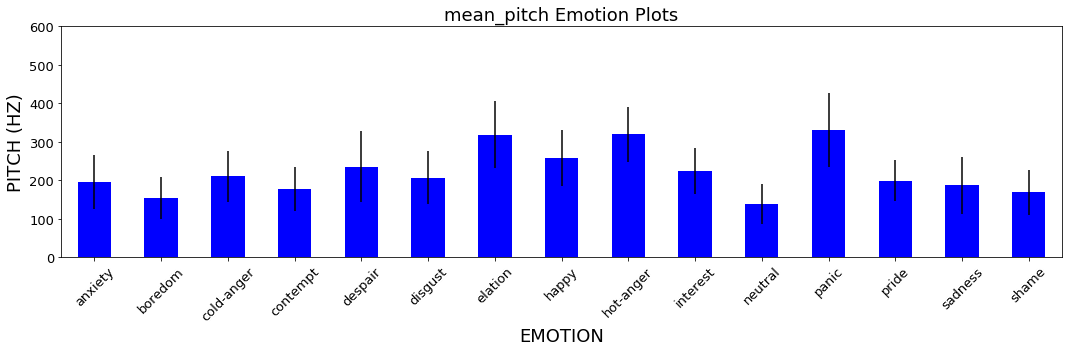

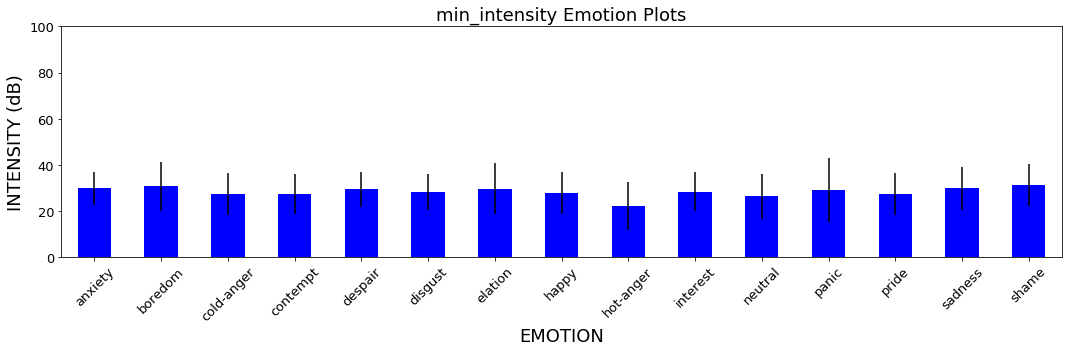

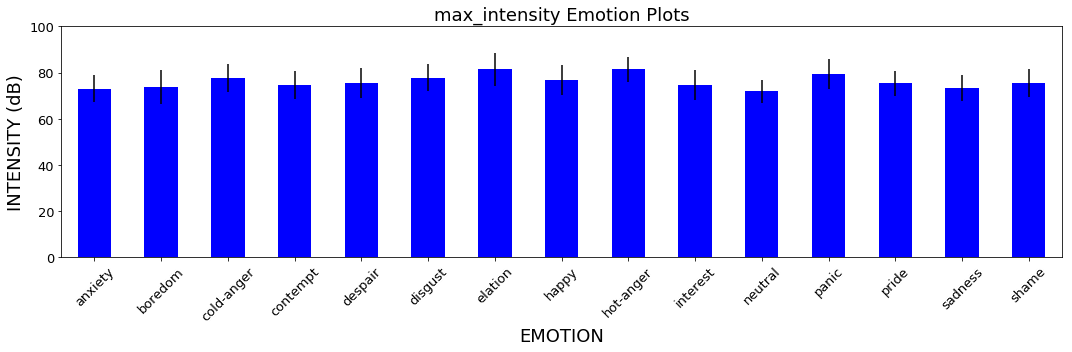

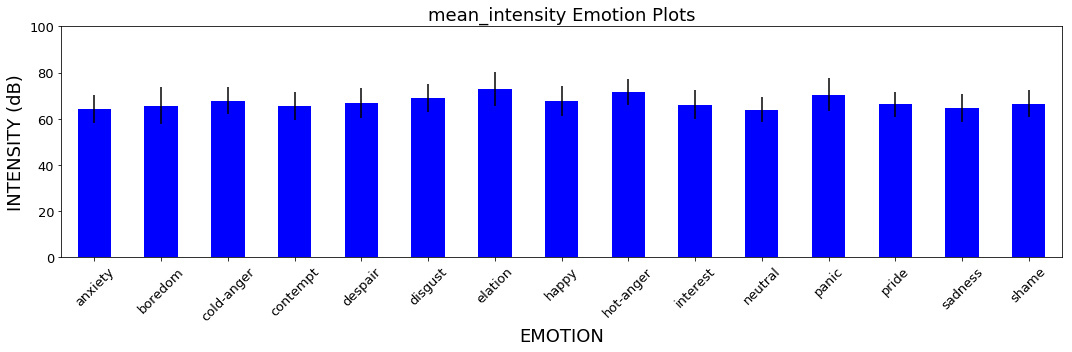

In [130]:
mean = df.groupby("emotion").mean()
std = df.groupby("emotion").std()
print (mean.columns)
for col in mean.columns: 
    plt.figure()
    p = mean[col].plot(figsize=(15,5),legend=False,kind="bar",rot=45,color="blue",fontsize=13,yerr=std[col]);
    p.set_title(col + " Emotion Plots", fontsize=18);
    p.set_xlabel("EMOTION", fontsize=18);
    # set y-label 
    if 'pitch' in col: 
        ylabel = 'PITCH (HZ)'
        p.set_ylim(0,600);
    else: 
        ylabel = 'INTENSITY (dB)'
        p.set_ylim(0,100);

    p.set_ylabel(ylabel, fontsize=18);
    plt.tight_layout()
    plt.savefig(col+'.png')

Index(['min_pitch', 'max_pitch', 'mean_pitch', 'min_intensity',
       'max_intensity', 'mean_intensity'],
      dtype='object')


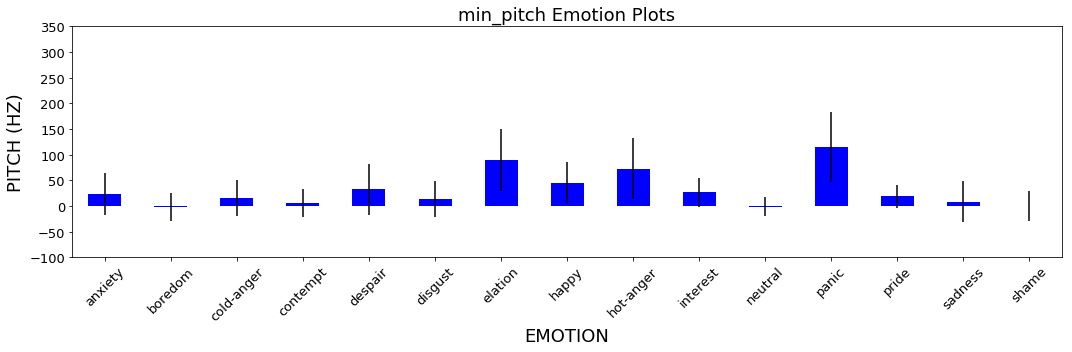

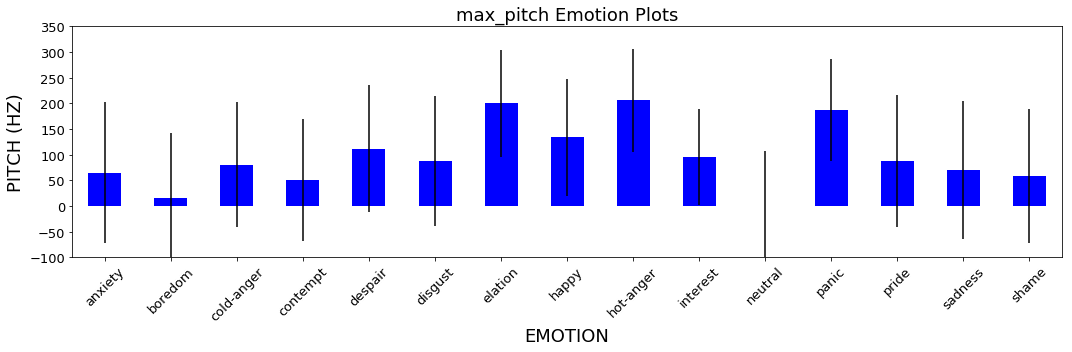

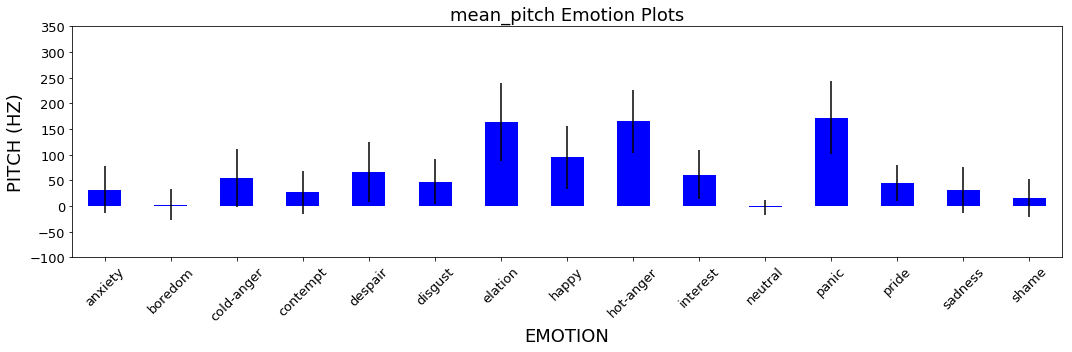

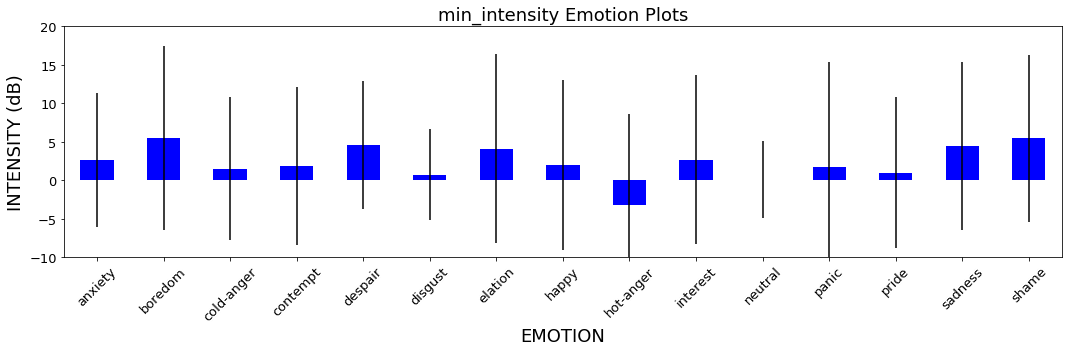

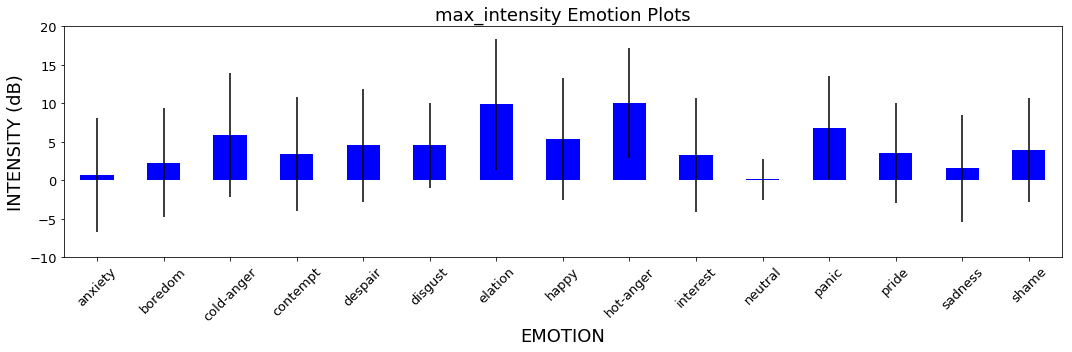

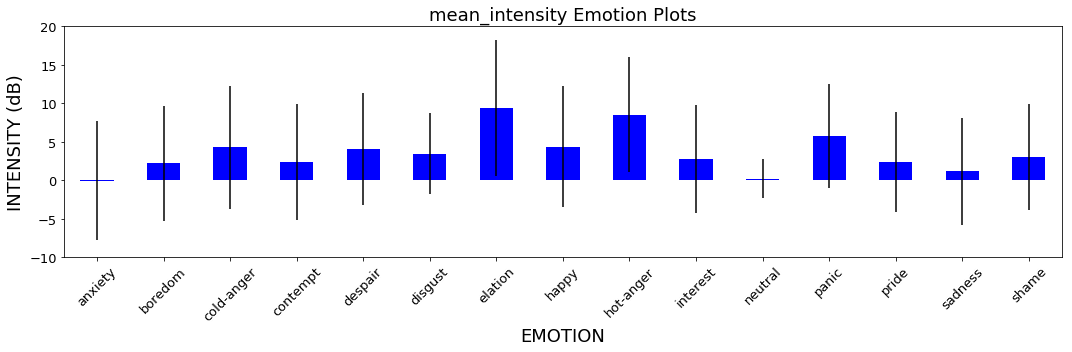

In [133]:
mean = norm_df.groupby("emotion").mean()
std = norm_df.groupby("emotion").std()
print (mean.columns)
for col in mean.columns: 
    plt.figure()
    p = mean[col].plot(figsize=(15,5),legend=False,kind="bar",rot=45,color="blue",fontsize=13,yerr=std[col]);
    p.set_title(col + " Emotion Plots", fontsize=18);
    p.set_xlabel("EMOTION", fontsize=18);
    # set y-label 
    if 'pitch' in col: 
        ylabel = 'PITCH (HZ)'
        p.set_ylim(-100,350);
    else: 
        ylabel = 'INTENSITY (dB)'
        p.set_ylim(-10,20);

    p.set_ylabel(ylabel, fontsize=18);
    plt.tight_layout()
    plt.savefig('norm_'+ col+'.png')